In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gillespy2
from scipy.optimize import minimize


In [2]:
def CLE(beta2, k2, n2, alpha, dt):
    x = [x0]
    for i in range(len(t) - 1):
        dxi = np.random.normal(0, 1, 3) 
        x_curr = x[-1]
        
        

        F = (
            
            beta2 * (pow(x_curr, n2) / (pow(k2, n2) + pow(x_curr, n2))) -
            alpha * x_curr)
        
        G = (
            
            np.sqrt(beta2 * (pow(x_curr, n2) / (pow(k2, n2) + pow(x_curr, n2)))) * dxi[1] +
            np.sqrt(alpha * x_curr) * dxi[2])
        
        x_next = x_curr + dt * F + np.sqrt(dt) * G

        x = np.hstack([x, x_next])
    return x


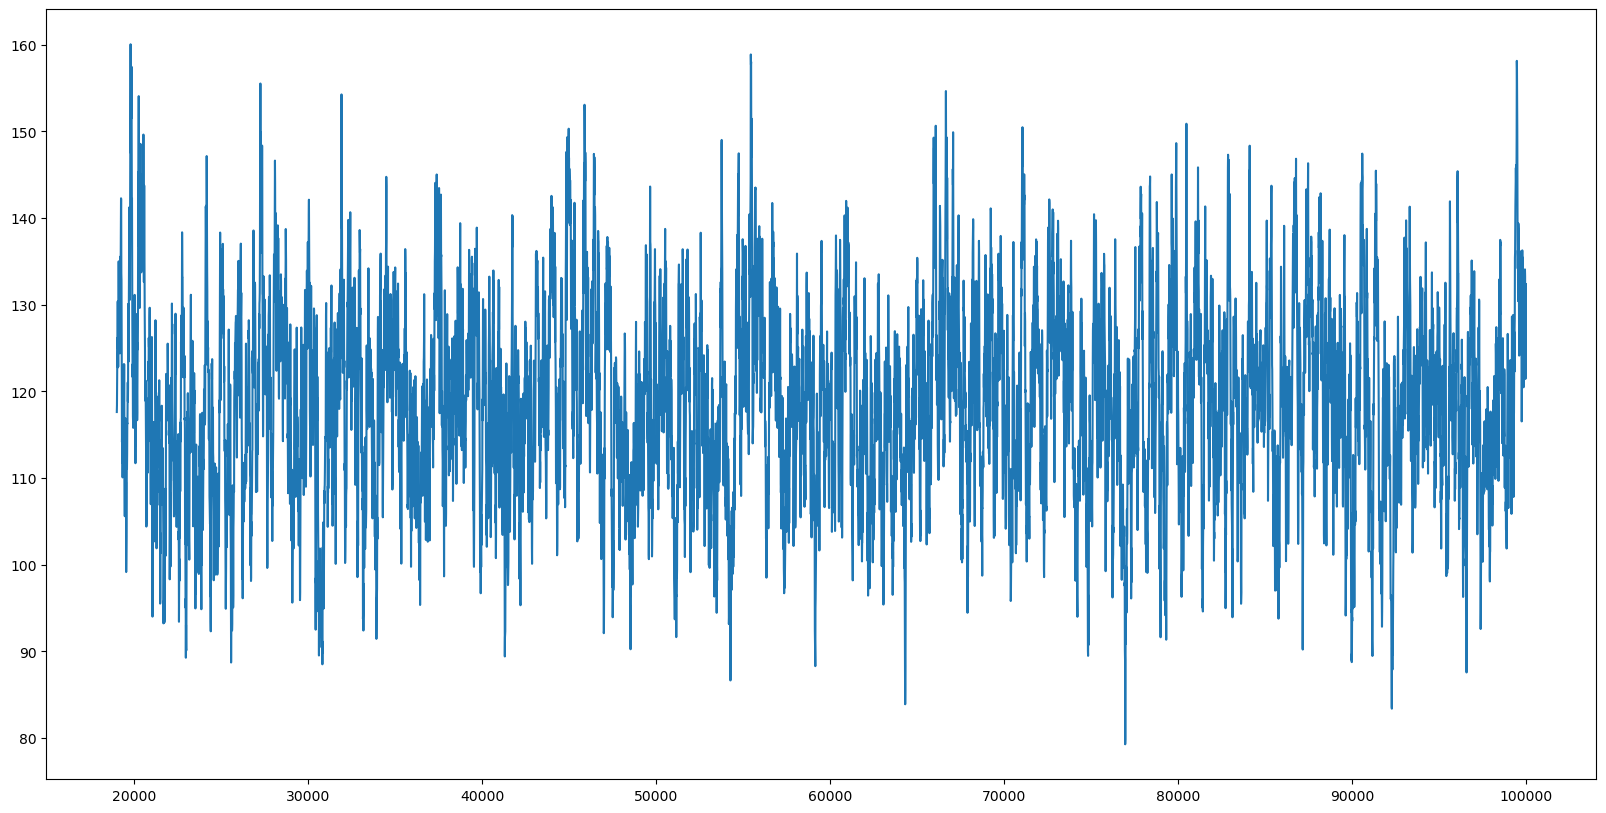

In [3]:

beta2=1.2
k2=1
n2=1
alpha=0.01
t = np.linspace(10000,100000,10000)
dt = t[1] - t[0]
x0=200
x_cle = CLE( beta2,k2, n2, alpha, dt)
x_cle_trimmed = x_cle[1000:]
t_trimmed = t[1000:]
plt.figure(figsize=(20, 10))
plt.plot(t_trimmed, x_cle_trimmed, label='cle')

In [4]:
def f_rep(x_cle_trimmed, k1, n1, beta1):
    return beta1 * (pow(k1, n1) / (pow(k1, n1) + pow(x_cle_trimmed, n1)))

def f_act(x_cle_trimmed, n2, k2, beta2):
    return beta2 * (pow(x_cle_trimmed, n2) / (pow(k2, n2) + pow(x_cle_trimmed, n2)))

def f_deg(x, alpha):
    return alpha * x_cle_trimmed

In [5]:
def fixed_point_act(x_cle_trimmed, k2, beta2, alpha):
    fact = f_act(x_cle_trimmed, n2, k2, beta2)
    fdeg = f_deg(x_cle_trimmed, alpha)
    
    diff_act = np.abs(fact - fdeg)
   
    fix_act_pt = x_cle_trimmed[np.where(diff_act < 0.005)[0][-1]]
   
    print('fix_act:', fix_act_pt)
   
    
    return fix_act_pt

#def fixed_point_rep(x_cle_trimmed, beta1, k1, n1, alpha):
    #frep = f_rep(x_cle_trimmed, k1, n1, beta1)
    #fdeg = f_deg(x_cle_trimmed, alpha)
    #diff_rep = np.abs(frep - fdeg)

    # Check if there are any points where diff_rep < 0.005
    #indices = np.where(diff_rep < 0.005)[0]
    
    #if len(indices) == 0:
        # No points satisfy the condition, handle this situation accordingly
        #print("No points satisfy the condition.")
        #return None
    #else:
        
        #fix_rep_pt = x_cle_trimmed[indices[-1]]
        #print('fix_rep:', fix_rep_pt)
        #return fix_rep_pt


In [6]:
from scipy.optimize import fixed_point

def fixed_point_rep(x_cle_trimmed, beta1, k1, n1, alpha):
    def equation_to_solve(x):
        frep = f_rep(x_cle_trimmed, k1, n1, beta1)
        fdeg = f_deg(x_cle_trimmed, alpha)
        return np.abs(frep - fdeg)

    # Initial guess for the root
    initial_guess = np.mean(x_cle_trimmed)

    # Use fixed_point to find the root
    fix_rep_pt = fixed_point(equation_to_solve, initial_guess)

    print("fix_rep_pt:", fix_rep_pt)

    if not np.isnan(fix_rep_pt).any():
        # Take the absolute value to ensure positivity
        fix_rep_pt = np.abs(fix_rep_pt)
        print('fix_rep:', fix_rep_pt)
        return fix_rep_pt[0]  # Extract the scalar value from the array
    else:
        print("Invalid fix_rep_pt found. Check your conditions or handle this case accordingly.")
        return None
  

In [7]:
fix_act_pt = fixed_point_act(x_cle_trimmed, k2, beta2, alpha)
#fix_rep_pt = fixed_point_rep(x_cle_trimmed, k1, beta1, alpha)


fix_act: 119.2096474297761


In [8]:
A=((-beta2*n2*pow(k2,n2)*pow(fix_act_pt,n2-1))/((pow(fix_act_pt,n2)+pow(k2,n2))**2))+alpha 
B=(beta2*pow(fix_act_pt,n2))/(pow(fix_act_pt,n2)+pow(k2,n2))+alpha*fix_act_pt

In [9]:
def A_r(fix_rep_pt, beta1, n1, K1, alpha):
    denominator = pow(fix_rep_pt, n1) + pow(K1, n1)
    
    # Handle division by zero or near-zero denominator
    if denominator == 0 or abs(denominator) < 1e-10:
        result = 0  # Set a default value or handle it according to your requirements
    else:
        numerator = beta1 * n1 * pow(K1, n1) * pow(fix_rep_pt, n1 - 1)
        result = (numerator / pow(denominator, 2)) + alpha
    
    print("A_r result:", result, "numerator:", numerator, "denominator:", denominator)
    
    return result

def B_r(fix_rep_pt, beta1, n1, K1, alpha):
    denominator = pow(fix_rep_pt, n1) + pow(K1, n1)
    
    # Handle division by zero or near-zero denominator
    if denominator == 0 or abs(denominator) < 1e-10:
        result = 0  # Set a default value or handle it according to your requirements
    else:
        numerator = beta1 * pow(K1, n1)
        result = (numerator / denominator) + alpha * fix_rep_pt
    
    print("B_r result:", result, "numerator:", numerator, "denominator:", denominator)
    
    return result


In [15]:
def cost_function(params, fix_act_pt, x_cle_trimmed, n2, k2, beta2, alpha,n1):
    beta1, K1 = params
    
    fix_rep_pt = fixed_point_rep(x_cle_trimmed, beta1, K1, n1, alpha)
    A = ((-beta2 * n2 * pow(k2, n2) * pow(fix_act_pt, n2 - 1)) / ((pow(fix_act_pt, n2) + pow(k2, n2))**2)) + alpha
    B = (beta2 * pow(fix_act_pt, n2)) / (pow(fix_act_pt, n2) + pow(k2, n2)) + alpha * fix_act_pt
    
   
    A_r_val = A_r(fix_rep_pt, beta1, n1, K1, alpha)
    B_r_val = B_r(fix_rep_pt, beta1, n1, K1, alpha)
    
    # Check for NaN values and return a large value
    if np.isnan(A_r_val) or np.isnan(B_r_val):
        return 1e6
    
    
    expression_diff = np.abs(A / (2 * B) - A_r_val / (2 * B_r_val)) + np.abs(fix_act_pt - fix_rep_pt)

    return np.sum(expression_diff)


In [16]:
def constraint(params):
    beta1, K1 = params
    return [beta1, K1]

# Set up the constraints
constraints_definition = ({'type': 'ineq', 'fun': lambda params: params[0]},  # beta1 >= 0
                          {'type': 'ineq', 'fun': lambda params: params[1]},  # K1 >= 0
                          )  

# Set up the bounds
bounds_definition = [(0, None), (0, None)] 

# Initial guess for parameters (beta1, K1, n1)
n1=1
initial_guess = [0.1, 1]

result = minimize(cost_function, initial_guess, args=(fix_act_pt, x_cle_trimmed, n2, k2, beta2, alpha,n1),
                  method='trust-constr', tol=1e-6, options={'maxiter': 1000},
                  constraints=constraints_definition, bounds=bounds_definition)

# Extract optimized parameters
optimized_params = result.x

# Print the optimized parameters
print("Optimized parameters (beta1, K1):", optimized_params)


fix_rep_pt: [1.17531454 1.18314282 1.21298409 ... 1.2157099  1.27307252 1.32306534]
fix_rep: [1.17531454 1.18314282 1.21298409 ... 1.2157099  1.27307252 1.32306534]
A_r result: 0.03113274311547929 numerator: 0.1 denominator: 2.175314541674167
B_r result: 0.05772350882130841 numerator: 0.1 denominator: 2.175314541674167
fix_rep_pt: [1.17531454 1.18314282 1.21298409 ... 1.2157099  1.27307252 1.32306534]
fix_rep: [1.17531454 1.18314282 1.21298409 ... 1.2157099  1.27307252 1.32306534]
A_r result: 0.031132746266944268 numerator: 0.1000000149011612 denominator: 2.1753145415485413
B_r result: 0.057723515672824924 numerator: 0.1000000149011612 denominator: 2.1753145415485413
fix_rep_pt: [1.17531454 1.18314282 1.21298409 ... 1.2157099  1.27307252 1.32306534]
fix_rep: [1.17531454 1.18314282 1.21298409 ... 1.2157099  1.27307252 1.32306534]
A_r result: 0.031132743141100164 numerator: 0.10000000149011612 denominator: 2.1753145565628715
B_r result: 0.057723509191556464 numerator: 0.10000000149011612

/Users/anshigupta/anaconda3/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


fix_rep_pt: [1.13934937 1.14740909 1.17810598 ... 1.18090792 1.23979877 1.29101812]
fix_rep: [1.13934937 1.14740909 1.17810598 ... 1.18090792 1.23979877 1.29101812]
A_r result: 0.2559158933781197 numerator: 4.443759371524027 denominator: 4.250910566453785
B_r result: 1.0567599632893432 numerator: 4.443759371524027 denominator: 4.250910566453785
fix_rep_pt: [1.13934937 1.14740909 1.17810598 ... 1.18090792 1.23979877 1.29101812]
fix_rep: [1.13934937 1.14740909 1.17810598 ... 1.18090792 1.23979877 1.29101812]
A_r result: 0.2559158971060121 numerator: 4.443759437741202 denominator: 4.2509105659053
B_r result: 1.0567599789959141 numerator: 4.443759437741202 denominator: 4.2509105659053
fix_rep_pt: [1.13934937 1.14740909 1.17810598 ... 1.18090792 1.23979877 1.29101812]
fix_rep: [1.13934937 1.14740909 1.17810598 ... 1.18090792 1.23979877 1.29101812]
A_r result: 0.2559158917398291 numerator: 4.443759437741202 denominator: 4.2509106122853115
B_r result: 1.0567599675904735 numerator: 4.443759437

fix_rep_pt: [1.14528584 1.15330603 1.18385692 ... 1.18664587 1.24527657 1.29628767]
fix_rep: [1.14528584 1.15330603 1.18385692 ... 1.18664587 1.24527657 1.29628767]
A_r result: 0.15618092401739855 numerator: 3.752053930921225 denominator: 5.066279956544969
B_r result: 0.752046343743124 numerator: 3.752053930921225 denominator: 5.066279956544969
fix_rep_pt: [1.14528584 1.15330603 1.18385692 ... 1.18664587 1.24527657 1.29628767]
fix_rep: [1.14528584 1.15330603 1.18385692 ... 1.18664587 1.24527657 1.29628767]
A_r result: 0.15618092054557672 numerator: 3.7520539284038192 denominator: 5.066280015007889
B_r result: 0.7520463347004215 numerator: 3.7520539284038192 denominator: 5.066280015007889
fix_rep_pt: [1.14554004 1.15355859 1.18410343 ... 1.18689185 1.24551174 1.29651416]
fix_rep: [1.14554004 1.15355859 1.18410343 ... 1.18689185 1.24551174 1.29651416]
A_r result: 0.154577706602902 numerator: 3.721369498428504 denominator: 5.073419001750403
B_r result: 0.7449586843214775 numerator: 3.7213

fix_rep_pt: [1.15362332 1.16158943 1.19194043 ... 1.19471161 1.25298549 1.30371038]
fix_rep: [1.15362332 1.16158943 1.19194043 ... 1.19471161 1.25298549 1.30371038]
A_r result: 0.09405177736508767 numerator: 2.753364314240632 denominator: 5.723456533113895
B_r result: 0.4926029274842149 numerator: 2.753364314240632 denominator: 5.723456533113895
fix_rep_pt: [1.15362332 1.16158943 1.19194043 ... 1.19471161 1.25298549 1.30371038]
fix_rep: [1.15362332 1.16158943 1.19194043 ... 1.19471161 1.25298549 1.30371038]
A_r result: 0.09405177946021334 numerator: 2.7533643823364535 denominator: 5.723456532556581
B_r result: 0.49260293942315925 numerator: 2.7533643823364535 denominator: 5.723456532556581
fix_rep_pt: [1.15362332 1.16158943 1.19194043 ... 1.19471161 1.25298549 1.30371038]
fix_rep: [1.15362332 1.16158943 1.19194043 ... 1.19471161 1.25298549 1.30371038]
A_r result: 0.09405177662700898 numerator: 2.7533643552689577 denominator: 5.723456600886488
B_r result: 0.4926029289530281 numerator: 2

fix_rep_pt: [1.1543012  1.16226237 1.19259522 ... 1.19536478 1.25360648 1.30430577]
fix_rep: [1.1543012  1.16226237 1.19259522 ... 1.19536478 1.25360648 1.30430577]
A_r result: 0.0781776348311988 numerator: 2.682526266168522 denominator: 6.272649574484201
B_r result: 0.4391974240721894 numerator: 2.682526266168522 denominator: 6.272649574484201
fix_rep_pt: [1.1543012  1.16226237 1.19259522 ... 1.19536478 1.25360648 1.30430577]
fix_rep: [1.1543012  1.16226237 1.19259522 ... 1.19536478 1.25360648 1.30430577]
A_r result: 0.07817763678312736 numerator: 2.6825263424378565 denominator: 6.272649573862782
B_r result: 0.4391974362673721 numerator: 2.6825263424378565 denominator: 6.272649573862782
fix_rep_pt: [1.1543012  1.16226237 1.19259522 ... 1.19536478 1.25360648 1.30430577]
fix_rep: [1.1543012  1.16226237 1.19259522 ... 1.19536478 1.25360648 1.30430577]
A_r result: 0.07817763419596148 numerator: 2.6825263061412783 denominator: 6.272649650441431
B_r result: 0.4391974252630314 numerator: 2.6

fix_rep_pt: [1.15471378 1.16267186 1.19299328 ... 1.19576184 1.25398334 1.3046666 ]
fix_rep: [1.15471378 1.16267186 1.19299328 ... 1.19576184 1.25398334 1.3046666 ]
A_r result: 0.06851214609454273 numerator: 2.641448630116227 denominator: 6.718898352596279
B_r result: 0.40468429979537907 numerator: 2.641448630116227 denominator: 6.718898352596279
fix_rep_pt: [1.15471709 1.16267514 1.19299647 ... 1.19576502 1.25398635 1.30466948]
fix_rep: [1.15471709 1.16267514 1.19299647 ... 1.19576502 1.25398635 1.30466948]
A_r result: 0.06842314127613719 numerator: 2.6411417766075815 denominator: 6.723623791344942
B_r result: 0.4043623935734796 numerator: 2.6411417766075815 denominator: 6.723623791344942
fix_rep_pt: [1.15471709 1.16267514 1.19299647 ... 1.19576502 1.25398635 1.30466948]
fix_rep: [1.15471709 1.16267514 1.19299647 ... 1.19576502 1.25398635 1.30466948]
A_r result: 0.06842314312346613 numerator: 2.6411418595907583 denominator: 6.723623790671294
B_r result: 0.4043624059481313 numerator: 2

fix_rep_pt: [1.15490538 1.16286183 1.1931773  ... 1.19594533 1.25415637 1.30483138]
fix_rep: [1.15490538 1.16286183 1.1931773  ... 1.19594533 1.25415637 1.30483138]
A_r result: 0.062053664885065446 numerator: 2.6259996658917353 denominator: 7.102670656307117
B_r result: 0.381269091896227 numerator: 2.6259996658917353 denominator: 7.102670656307117
fix_rep_pt: [1.15490538 1.16286183 1.1931773  ... 1.19594533 1.25415637 1.30483138]
fix_rep: [1.15490538 1.16286183 1.1931773  ... 1.19594533 1.25415637 1.30483138]
A_r result: 0.06205366665241226 numerator: 2.6259997545203446 denominator: 7.102670655589845
B_r result: 0.3812691044046 numerator: 2.6259997545203446 denominator: 7.102670655589845
fix_rep_pt: [1.15490538 1.16286183 1.1931773  ... 1.19594533 1.25415637 1.30483138]
fix_rep: [1.15490538 1.16286183 1.1931773  ... 1.19594533 1.25415637 1.30483138]
A_r result: 0.062053664366070835 numerator: 2.62599970502218 denominator: 7.1026707446342865
B_r result: 0.3812690928047176 numerator: 2.6

fix_rep_pt: [1.15495051 1.16290631 1.19321941 ... 1.19598723 1.25419421 1.30486611]
fix_rep: [1.15495051 1.16290631 1.19321941 ... 1.19598723 1.25419421 1.30486611]
A_r result: 0.05740851324384226 numerator: 2.6276797337430473 denominator: 7.444885929011809
B_r result: 0.36450047822380044 numerator: 2.6276797337430473 denominator: 7.444885929011809
fix_rep_pt: [1.15495051 1.16290631 1.19321941 ... 1.19598723 1.25419421 1.30486611]
fix_rep: [1.15495051 1.16290631 1.19321941 ... 1.19598723 1.25419421 1.30486611]
A_r result: 0.05740851494450188 numerator: 2.627679827470389 denominator: 7.444885928255367
B_r result: 0.3645004908415912 numerator: 2.627679827470389 denominator: 7.444885928255367
fix_rep_pt: [1.15495051 1.16290631 1.19321941 ... 1.19598723 1.25419421 1.30486611]
fix_rep: [1.15495051 1.16290631 1.19321941 ... 1.19598723 1.25419421 1.30486611]
A_r result: 0.057408512760406205 numerator: 2.6276797728985266 denominator: 7.4448860224391815
B_r result: 0.36450047905092725 numerator

fix_rep_pt: [1.15490209 1.16285786 1.19317086 ... 1.19593867 1.25414562 1.30481763]
fix_rep: [1.15490209 1.16285786 1.19317086 ... 1.19593867 1.25414562 1.30481763]
A_r result: 0.05378657509017248 numerator: 2.640495088805117 denominator: 7.765549522812948
B_r result: 0.3515758382415572 numerator: 2.640495088805117 denominator: 7.765549522812948
fix_rep_pt: [1.15490209 1.16285786 1.19317086 ... 1.19593867 1.25414562 1.30481763]
fix_rep: [1.15490209 1.16285786 1.19317086 ... 1.19593867 1.25414562 1.30481763]
A_r result: 0.05378657299271148 numerator: 2.6404950296452356 denominator: 7.765549621812352
B_r result: 0.35157582629339545 numerator: 2.6404950296452356 denominator: 7.765549621812352
fix_rep_pt: [1.15490121 1.16285697 1.19316998 ... 1.1959378  1.25414476 1.30481678]
fix_rep: [1.15490121 1.16285697 1.19316998 ... 1.1959378  1.25414476 1.30481678]
A_r result: 0.05375225541684075 numerator: 2.6406757114960766 denominator: 7.768860310434133
B_r result: 0.3514541726711378 numerator: 2

fix_rep_pt: [1.15480674 1.16276281 1.19307698 ... 1.1958449  1.25405406 1.30472796]
fix_rep: [1.15480674 1.16276281 1.19307698 ... 1.1958449  1.25405406 1.30472796]
A_r result: 0.051137157613255546 numerator: 2.6581696424289163 denominator: 8.03848501657327
B_r result: 0.34222849253309845 numerator: 2.6581696424289163 denominator: 8.03848501657327
fix_rep_pt: [1.15480545 1.16276153 1.19307571 ... 1.19584363 1.25405282 1.30472676]
fix_rep: [1.15480545 1.16276153 1.19307571 ... 1.19584363 1.25405282 1.30472676]
A_r result: 0.05110952712887524 numerator: 2.6583955299403836 denominator: 8.041527628167623
B_r result: 0.3421314526990466 numerator: 2.6583955299403836 denominator: 8.041527628167623
fix_rep_pt: [1.15480545 1.16276153 1.19307571 ... 1.19584363 1.25405282 1.30472676]
fix_rep: [1.15480545 1.16276153 1.19307571 ... 1.19584363 1.25405282 1.30472676]
A_r result: 0.051109528724224466 numerator: 2.658395632560541 denominator: 8.041527627343381
B_r result: 0.34213146548596485 numerator:

fix_rep_pt: [1.15467492 1.16263152 1.19294769 ... 1.19571579 1.25392867 1.30460568]
fix_rep: [1.15467492 1.16263152 1.19294769 ... 1.19571579 1.25392867 1.30460568]
A_r result: 0.04881366304907794 numerator: 2.6804203617711075 denominator: 8.31015527294858
B_r result: 0.3340943158708684 numerator: 2.6804203617711075 denominator: 8.31015527294858
fix_rep_pt: [1.15467492 1.16263153 1.19294769 ... 1.19571579 1.25392867 1.30460568]
fix_rep: [1.15467492 1.16263153 1.19294769 ... 1.19571579 1.25392867 1.30460568]
A_r result: 0.04881366108229483 numerator: 2.6804202950875156 denominator: 8.31015538012635
B_r result: 0.3340943036920851 numerator: 2.6804202950875156 denominator: 8.31015538012635
fix_rep_pt: [1.15467341 1.16263002 1.19294621 ... 1.19571431 1.25392723 1.30460428]
fix_rep: [1.15467341 1.16263002 1.19294621 ... 1.19571431 1.25392723 1.30460428]
A_r result: 0.048791080654200326 numerator: 2.6806695407703653 denominator: 8.312960187867704
B_r result: 0.33401544320534005 numerator: 2.

fix_rep_pt: [1.15453859 1.16249579 1.19281419 ... 1.19558249 1.25379949 1.30447991]
fix_rep: [1.15453859 1.16249579 1.19281419 ... 1.19558249 1.25379949 1.30447991]
A_r result: 0.047003972753818825 numerator: 2.7025316502593113 denominator: 8.545967131592988
B_r result: 0.327780120792863 numerator: 2.7025316502593113 denominator: 8.545967131592988
fix_rep_pt: [1.15453859 1.16249579 1.19281419 ... 1.19558249 1.25379949 1.30447991]
fix_rep: [1.15453859 1.16249579 1.19281419 ... 1.19558249 1.25379949 1.30447991]
A_r result: 0.047003970838311676 numerator: 2.702531580389301 denominator: 8.545967242311832
B_r result: 0.32778010852581846 numerator: 2.702531580389301 denominator: 8.545967242311832
fix_rep_pt: [1.15453699 1.16249419 1.19281262 ... 1.19558093 1.25379797 1.30447844]
fix_rep: [1.15453699 1.16249419 1.19281262 ... 1.19558093 1.25379797 1.30447844]
A_r result: 0.04698481984659299 numerator: 2.702788605812126 denominator: 8.54858601547004
B_r result: 0.3277132836026269 numerator: 2.

In [17]:

optimized_params = [0.37667698, 7.45060611]


fix_rep_pt_optimized = fixed_point_rep(x_cle_trimmed, optimized_params[0], optimized_params[1], n1, alpha)
print("Fixed point value at optimized parameters:", fix_rep_pt_optimized)


fix_rep_pt: [1.15371774 1.16167998 1.19201703 ... 1.194787   1.25303742 1.30374477]
fix_rep: [1.15371774 1.16167998 1.19201703 ... 1.194787   1.25303742 1.30374477]
Fixed point value at optimized parameters: 1.1537177394658555
